In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


In [4]:
def load_processed_data(train_path='../../data/processed/train_data.csv',
                       test_path='../../data/processed/test_data.csv'):
    """
    Load the preprocessed training and test datasets
    """
    train = pd.read_csv(train_path, parse_dates=['Datetime'])
    test = pd.read_csv(test_path, parse_dates=['Datetime'])
    
    print("Training data shape:", train.shape)
    print("Test data shape:", test.shape)
    
    return train, test

def prepare_features(data):
    """
    Prepare features for ML models
    """
    # Drop non-feature columns
    feature_cols = [col for col in data.columns 
                   if col not in ['Datetime', 'PJME', 'timeofday']]
    
    X = data[feature_cols]
    y = data['PJME']
    
    return X, y

def train_random_forest(X_train, y_train, X_test, y_test):
    """
    Train and evaluate Random Forest model
    """
    # Initialize model
    rf = RandomForestRegressor(n_estimators=100, 
                             max_depth=20,
                             random_state=42,
                             n_jobs=-1)
    
    # Train model
    rf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf.predict(X_test)
    
    # Calculate metrics
    metrics = evaluate_predictions(y_test, y_pred)
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return rf, metrics, feature_importance

def train_xgboost(X_train, y_train, X_test, y_test):
    """
    Train and evaluate XGBoost model
    """
    # Initialize model
    xgb = XGBRegressor(n_estimators=100,
                      max_depth=7,
                      learning_rate=0.1,
                      random_state=42)
    
    # Train model
    xgb.fit(X_train, y_train)
    
    # Make predictions
    y_pred = xgb.predict(X_test)
    
    # Calculate metrics
    metrics = evaluate_predictions(y_test, y_pred)
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return xgb, metrics, feature_importance

def evaluate_predictions(y_true, y_pred):
    """
    Calculate regression metrics
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    return metrics

def plot_feature_importance(importance_df, title):
    """
    Plot feature importance
    """
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=importance_df.head(15))
    plt.title(f'Top 15 Feature Importance - {title}')
    plt.show()

def plot_predictions(y_true, y_pred, title):
    """
    Plot actual vs predicted values
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted - {title}')
    plt.tight_layout()
    plt.show()
    
    # Plot residuals
    residuals = y_pred - y_true
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=50)
    plt.xlabel('Residual Error')
    plt.ylabel('Count')
    plt.title(f'Residual Distribution - {title}')
    plt.tight_layout()
    plt.show()

def analyze_temporal_errors(y_true, y_pred, timestamps):
    """
    Analyze prediction errors across different time periods
    """
    errors = pd.DataFrame({
        'datetime': timestamps,
        'error': y_pred - y_true,
        'abs_error': np.abs(y_pred - y_true)
    })
    
    # Add time components
    errors['hour'] = errors['datetime'].dt.hour
    errors['month'] = errors['datetime'].dt.month
    errors['dayofweek'] = errors['datetime'].dt.dayofweek
    
    # Hourly analysis
    hourly_mae = errors.groupby('hour')['abs_error'].mean()
    
    plt.figure(figsize=(12, 4))
    hourly_mae.plot(kind='bar')
    plt.title('Mean Absolute Error by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('MAE')
    plt.tight_layout()
    plt.show()
    
    # Monthly analysis
    monthly_mae = errors.groupby('month')['abs_error'].mean()
    
    plt.figure(figsize=(12, 4))
    monthly_mae.plot(kind='bar')
    plt.title('Mean Absolute Error by Month')
    plt.xlabel('Month')
    plt.ylabel('MAE')
    plt.tight_layout()
    plt.show()
    
    # Day of week analysis
    dow_mae = errors.groupby('dayofweek')['abs_error'].mean()
    
    plt.figure(figsize=(12, 4))
    dow_mae.plot(kind='bar')
    plt.title('Mean Absolute Error by Day of Week')
    plt.xlabel('Day of Week (0=Monday)')
    plt.ylabel('MAE')
    plt.tight_layout()
    plt.show()
    
    return errors

def create_ensemble_prediction(models, weights, X):
    """
    Create weighted ensemble prediction
    """
    predictions = np.column_stack([model.predict(X) for model in models])
    return np.average(predictions, weights=weights, axis=1)

def compare_models(metrics_rf, metrics_xgb, metrics_ensemble=None):
    """
    Compare metrics from different models
    """
    metrics_dict = {
        'Random Forest': metrics_rf,
        'XGBoost': metrics_xgb
    }
    
    if metrics_ensemble is not None:
        metrics_dict['Ensemble'] = metrics_ensemble
    
    comparison = pd.DataFrame(metrics_dict).T
    return comparison

# Grid search for best ensemble weights
def optimize_ensemble_weights(models, X, y, n_splits=10):
    """
    Find optimal weights for ensemble using grid search
    """
    best_score = float('inf')
    best_weights = None
    
    # Try different weight combinations
    for w1 in range(1, 10):
        w2 = 10 - w1
        weights = [w1/10, w2/10]
        
        # Make ensemble prediction
        y_pred = create_ensemble_prediction(models, weights, X)
        score = mean_squared_error(y, y_pred)
        
        if score < best_score:
            best_score = score
            best_weights = weights
    
    return best_weights

Training data shape: (114565, 29)
Test data shape: (28642, 29)

Training Random Forest...
Random Forest Metrics:
RMSE    397.928990
MAE     289.881250
R2        0.996252
dtype: float64


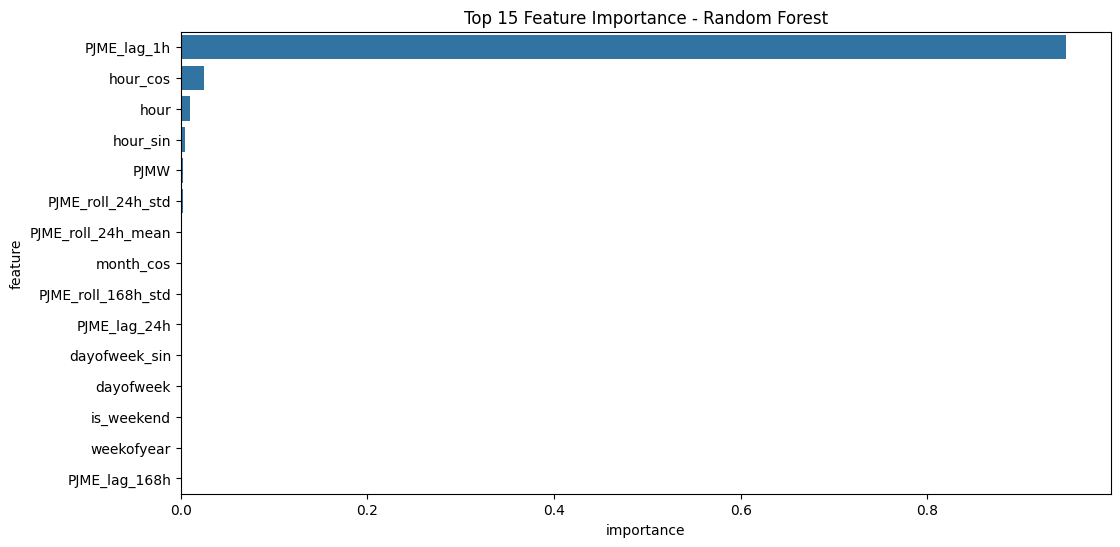

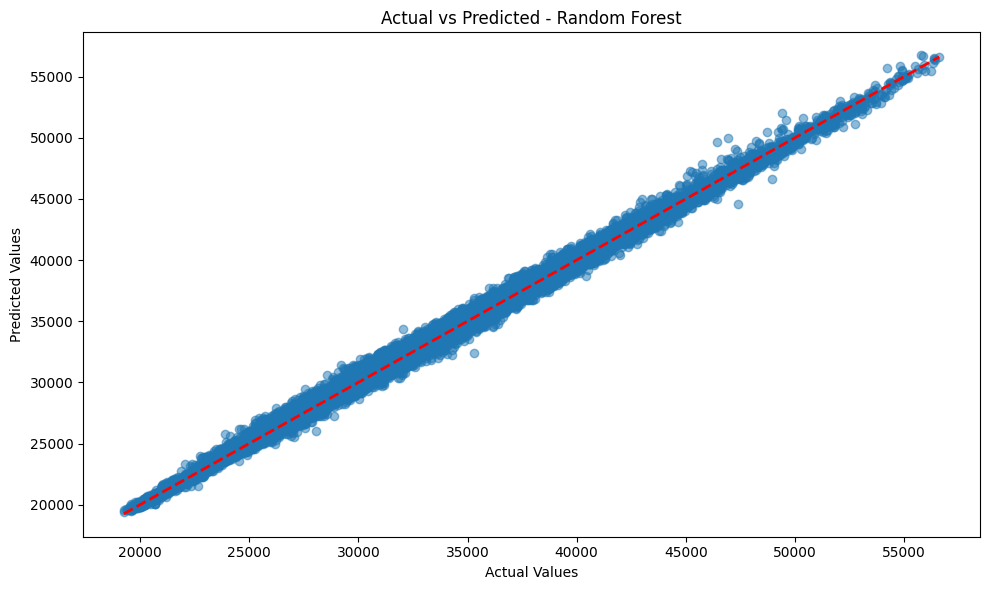

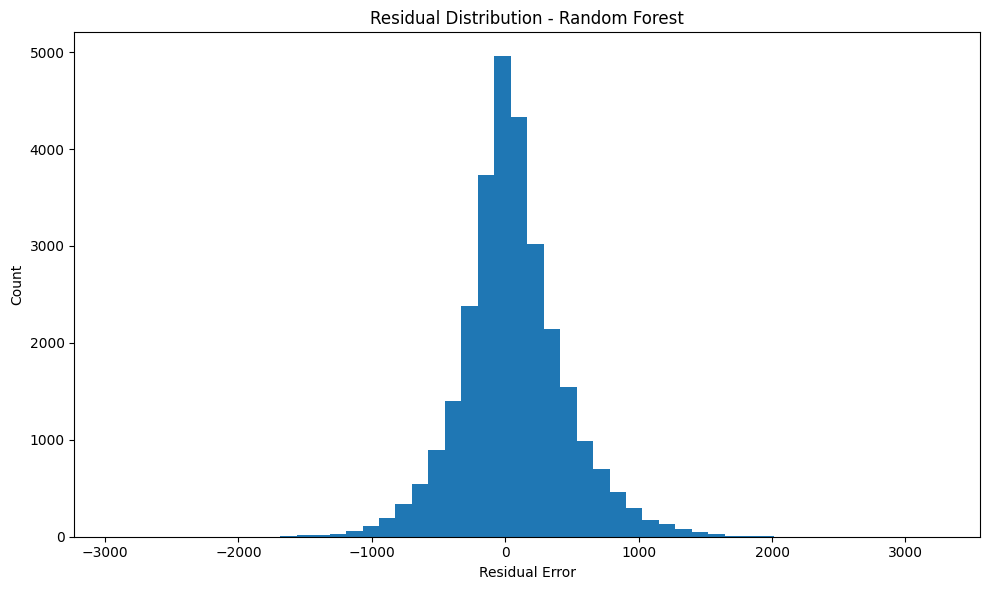


Training XGBoost...
XGBoost Metrics:
RMSE    378.979671
MAE     280.801723
R2        0.996600
dtype: float64


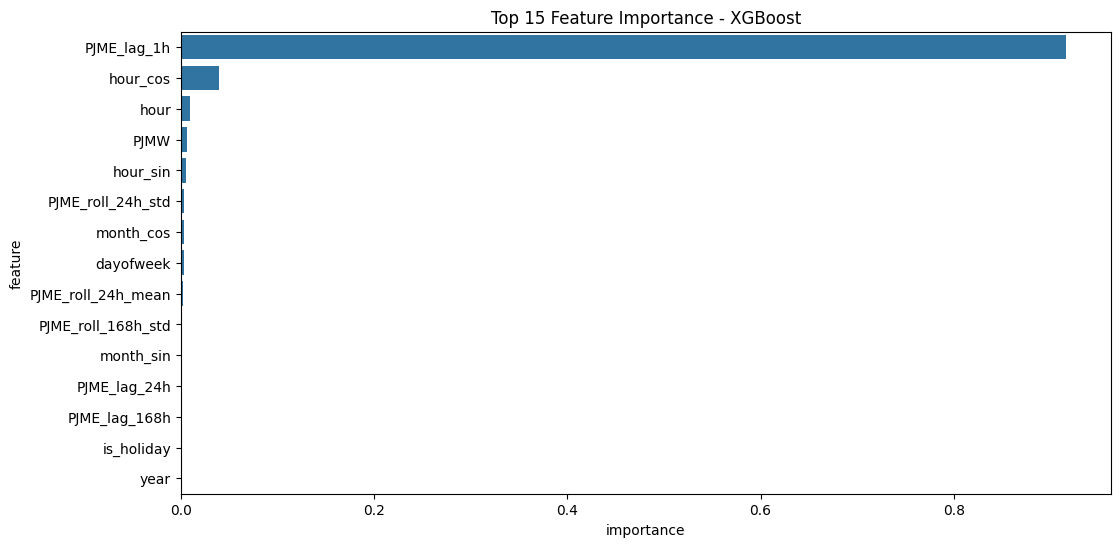

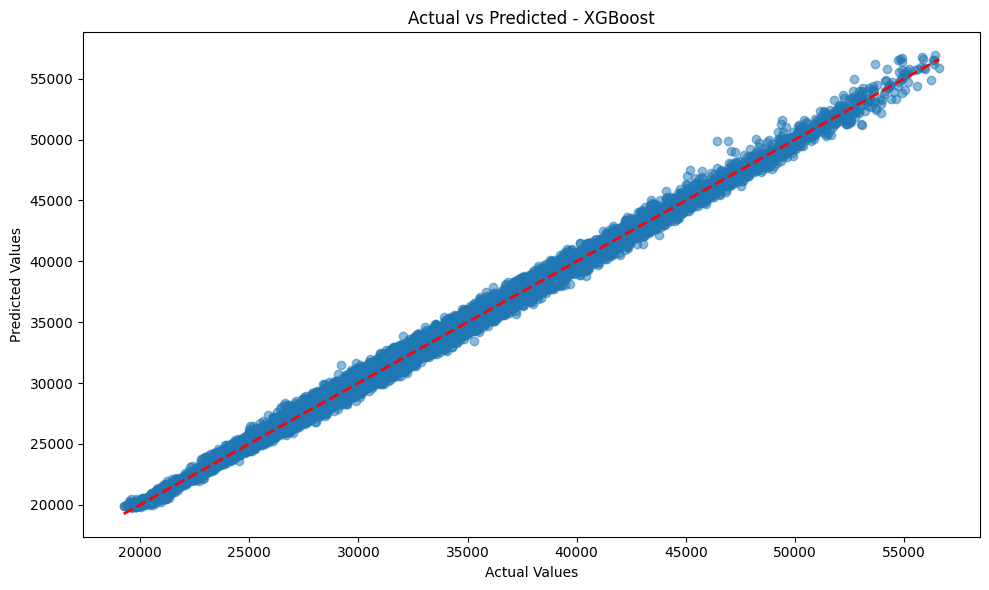

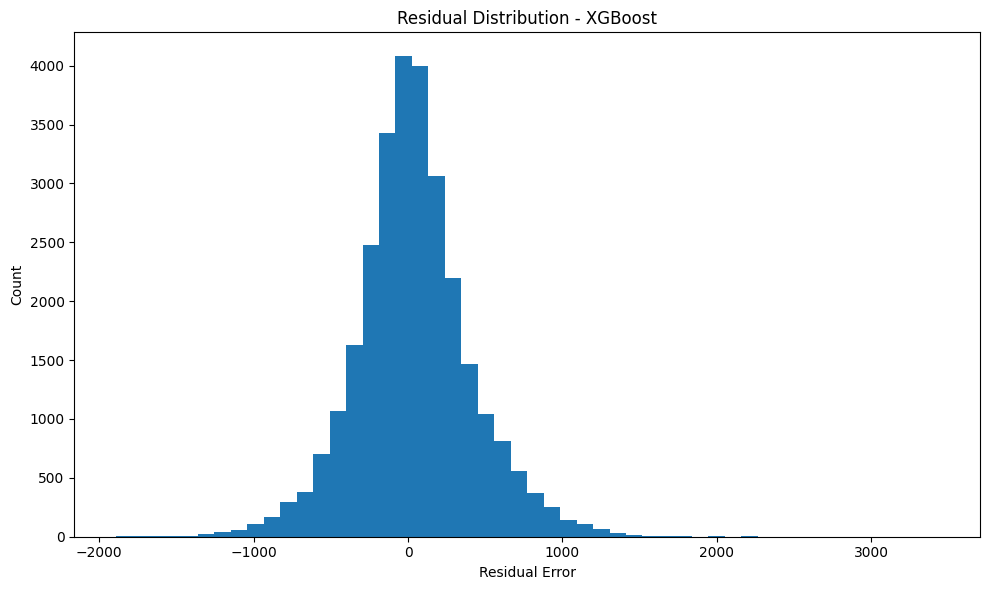


Analyzing Random Forest temporal errors...


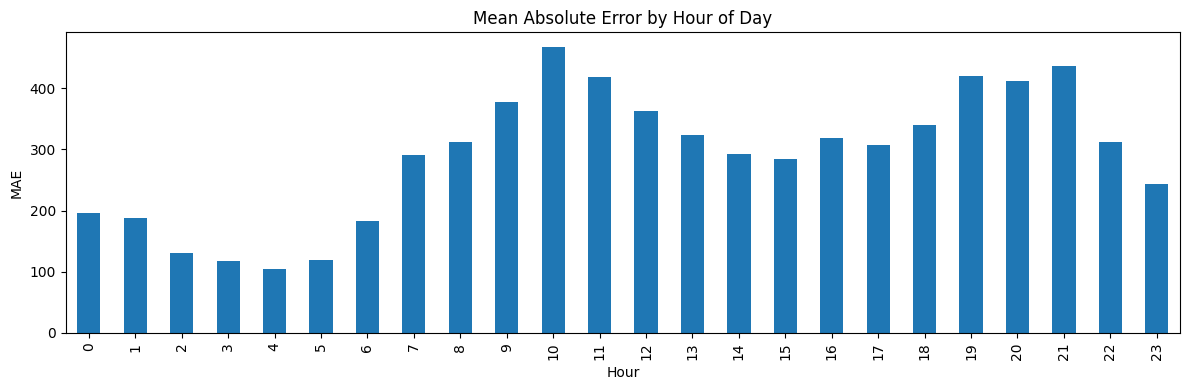

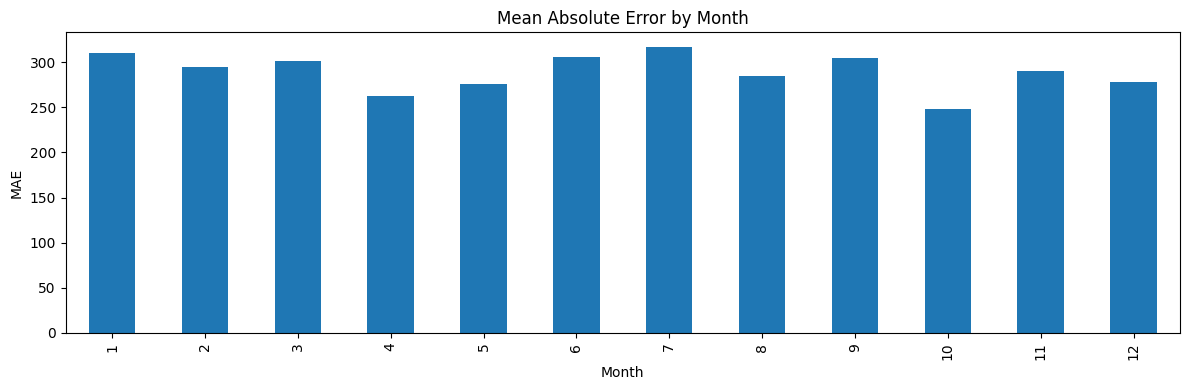

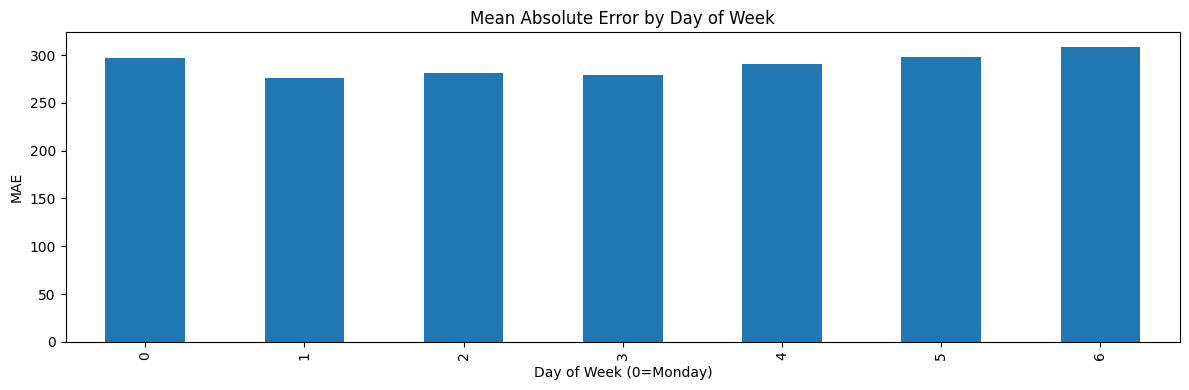


Analyzing XGBoost temporal errors...


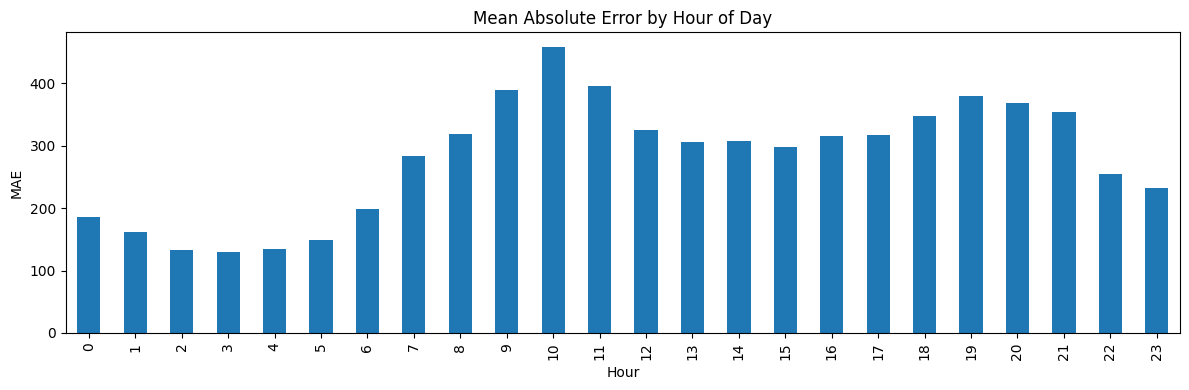

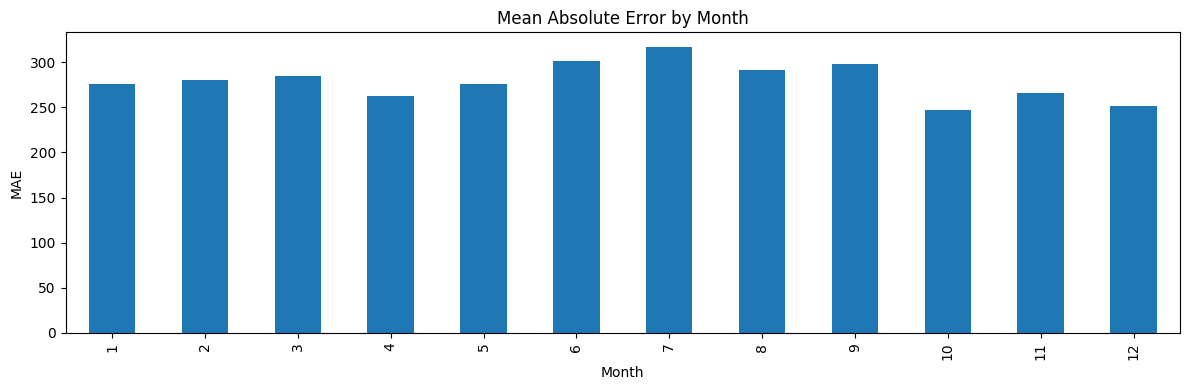

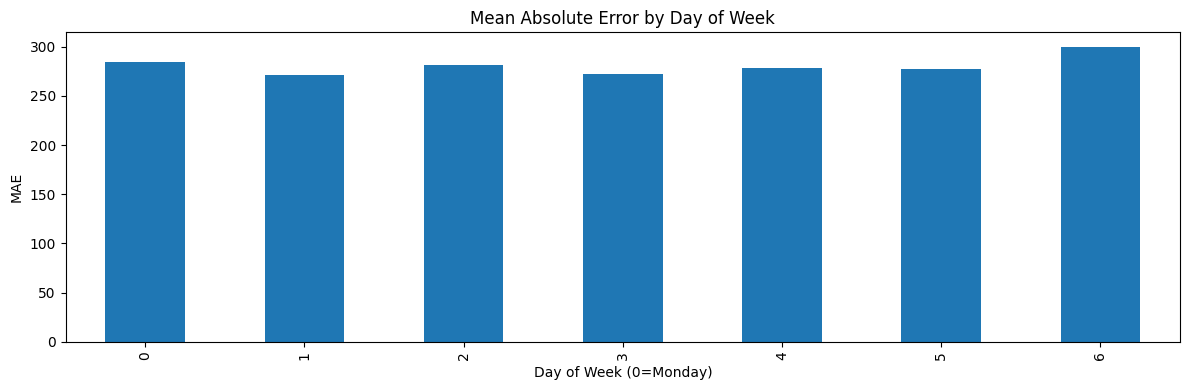


Optimizing ensemble weights...
Best ensemble weights: RF=0.40, XGB=0.60

Ensemble Metrics:
RMSE    367.120440
MAE     269.706807
R2        0.996810
dtype: float64


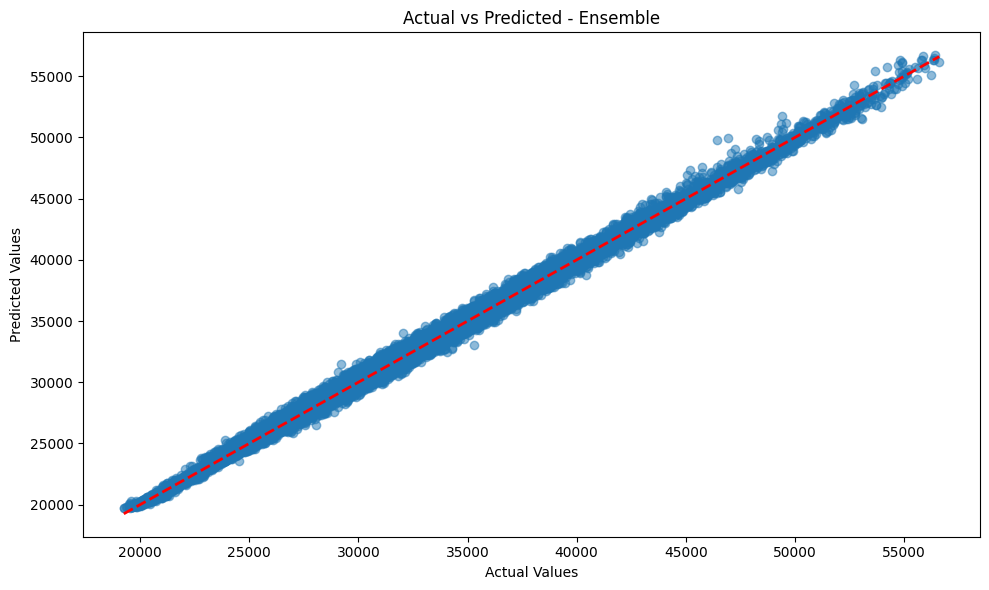

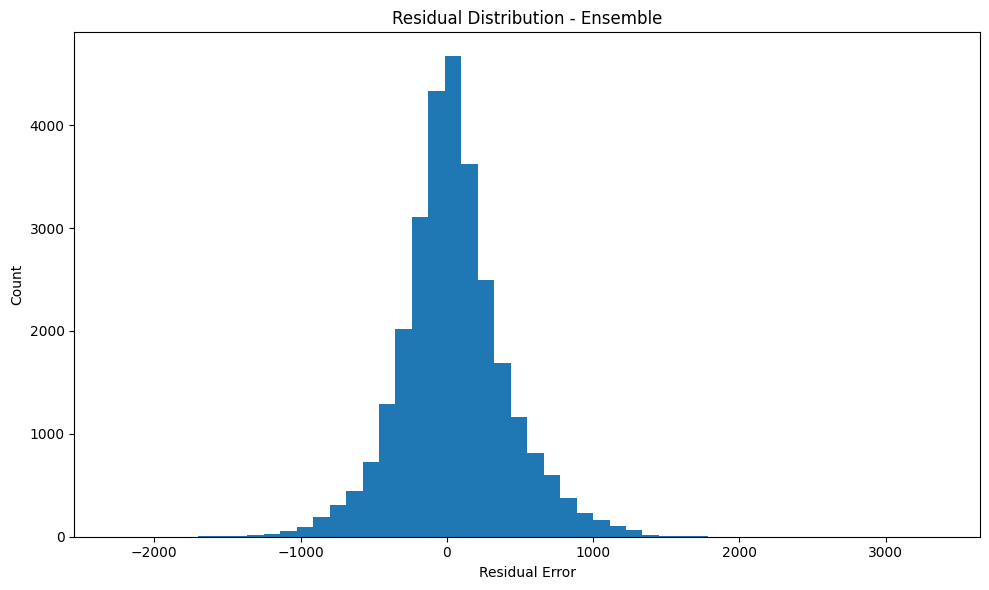


Analyzing Ensemble temporal errors...


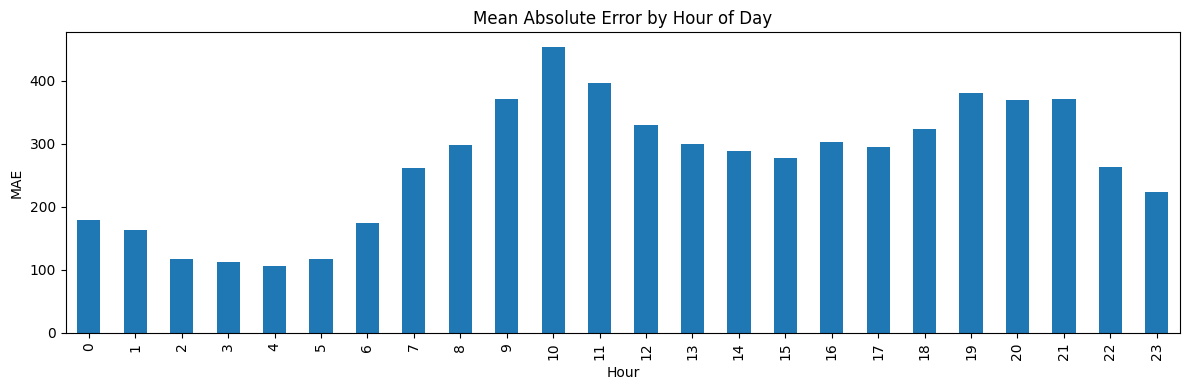

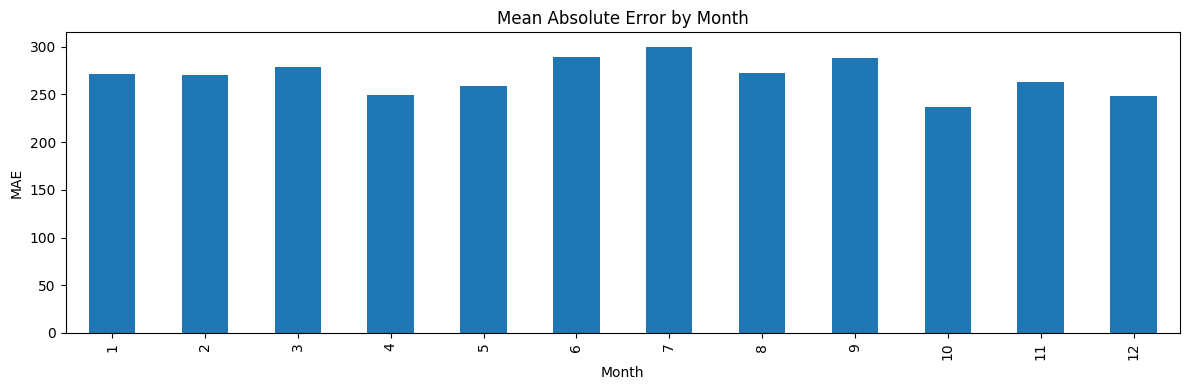

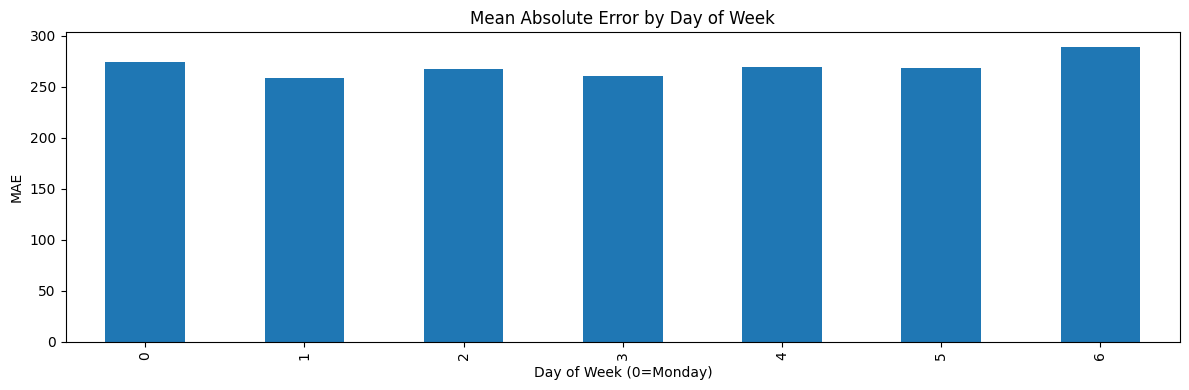


Model Comparison:
                     RMSE         MAE        R2
Random Forest  397.928990  289.881250  0.996252
XGBoost        378.979671  280.801723  0.996600
Ensemble       367.120440  269.706807  0.996810

Saving models and results...


In [6]:
# Main execution
if __name__ == "__main__":
    # Load data
    train_data, test_data = load_processed_data()
    
    # Prepare features
    X_train, y_train = prepare_features(train_data)
    X_test, y_test = prepare_features(test_data)
    
    # Train and evaluate Random Forest
    print("\nTraining Random Forest...")
    rf_model, rf_metrics, rf_importance = train_random_forest(X_train, y_train, X_test, y_test)
    print("Random Forest Metrics:")
    print(pd.Series(rf_metrics))
    plot_feature_importance(rf_importance, "Random Forest")
    plot_predictions(y_test, rf_model.predict(X_test), "Random Forest")
    
    # Train and evaluate XGBoost
    print("\nTraining XGBoost...")
    xgb_model, xgb_metrics, xgb_importance = train_xgboost(X_train, y_train, X_test, y_test)
    print("XGBoost Metrics:")
    print(pd.Series(xgb_metrics))
    plot_feature_importance(xgb_importance, "XGBoost")
    plot_predictions(y_test, xgb_model.predict(X_test), "XGBoost")
    
    # Temporal error analysis
    print("\nAnalyzing Random Forest temporal errors...")
    rf_errors = analyze_temporal_errors(y_test, 
                                      rf_model.predict(X_test),
                                      test_data['Datetime'])
    
    print("\nAnalyzing XGBoost temporal errors...")
    xgb_errors = analyze_temporal_errors(y_test,
                                       xgb_model.predict(X_test),
                                       test_data['Datetime'])
    
    # Create and evaluate ensemble
    print("\nOptimizing ensemble weights...")
    models = [rf_model, xgb_model]
    best_weights = optimize_ensemble_weights(models, X_test, y_test)
    print(f"Best ensemble weights: RF={best_weights[0]:.2f}, XGB={best_weights[1]:.2f}")
    
    # Make ensemble predictions
    y_pred_ensemble = create_ensemble_prediction(models, best_weights, X_test)
    ensemble_metrics = evaluate_predictions(y_test, y_pred_ensemble)
    
    # Plot ensemble results
    print("\nEnsemble Metrics:")
    print(pd.Series(ensemble_metrics))
    plot_predictions(y_test, y_pred_ensemble, "Ensemble")
    
    # Analyze ensemble temporal errors
    print("\nAnalyzing Ensemble temporal errors...")
    ensemble_errors = analyze_temporal_errors(y_test,
                                            y_pred_ensemble,
                                            test_data['Datetime'])
    
    # Compare all models
    comparison = compare_models(rf_metrics, xgb_metrics, ensemble_metrics)
    print("\nModel Comparison:")
    print(comparison)
    
    # Save models and results
    print("\nSaving models and results...")
    import joblib
    joblib.dump(rf_model, '../models/random_forest.joblib')
    joblib.dump(xgb_model, '../models/xgboost.joblib')
    comparison.to_csv('../results/model_comparison.csv')